# Overview Seperate Chains
Overview when using a seperate model for the alpha chain and beta chain. The test data doesn't contain NaN's here.

| Model Alpha       | Model Beta        | AUC Alpha | AUC Beta | AUC Combined |
|-------------------|-------------------|-----------|----------|--------------|
| RF (mean imputed) | RF (mean imputed) | 0.890     | 0.911    | 0.954        |
| HistGradient      | HistGradient      | 0.922     | 0.917    | 0.967        |
| XGB               | XGB               | 0.916     | 0.929    | 0.967        |
| HistGradient      | XGB               | 0.922     | 0.929    | 0.966        |

## Data

In [27]:
from sklearn.model_selection import train_test_split
from util import get_train_dataset, get_features, fix_test, evaluate, calculate_auc_and_plot, get_columns_starting_with
import numpy as np
import pandas as pd

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

train, test = train_test_split(df, test_size=0.2, random_state=42)

test.dropna(inplace=True)
x = get_features(train)
y = train['reaction']
x_test = get_features(test, test=True)
x_test = fix_test(x_test, x.columns)
y_test = test['reaction']

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


## Evaluation

In [42]:
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.ensemble import VotingClassifier

def evaluate_seperate_chains(clf1, clf2, x, y, x_test, y_test):
    # Keep only the columns starting with 'alfa_'
    x_alpha = get_columns_starting_with(x, 'alfa_')
    x_beta = get_columns_starting_with(x, 'beta_')

    clf1.fit(x_alpha, y)
    clf2.fit(x_beta, y)

    x_test_alpha = get_columns_starting_with(x_test, 'alfa_')
    x_test_beta = get_columns_starting_with(x_test, 'beta_')

    x_test_alpha = fix_test(x_test_alpha, x_alpha.columns)
    x_test_beta = fix_test(x_test_beta, x_beta.columns)

    y_pred1 = clf1.predict_proba(x_test_alpha)[:, 1]
    y_pred2 = clf2.predict_proba(x_test_beta)[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred1, pos_label=1)
    auc_alpha = metrics.auc(fpr, tpr)
    print(f"alpha: {auc_alpha:.3f}")

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred2, pos_label=1)
    auc_beta = metrics.auc(fpr, tpr)
    print(f"beta: {auc_beta:.3f}")

    y_pred = (y_pred1 + y_pred2) / 2
    auc = calculate_auc_and_plot(y_test, y_pred)

    print(f"combined: {auc:.3f}")

    # Code below doesn't work yet (since I still need to figure out how I can give two seperate input streams to the VotingClassifier)
    # # alpha model
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # scores = cross_val_score(clf1, x, y, cv=kf, scoring='roc_auc')
    # print(scores)
    # print(f"ROC alpha: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    #
    # # beta model
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # scores = cross_val_score(clf2, x, y, cv=kf, scoring='roc_auc')
    # print(scores)
    # print(f"ROC beta: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    #
    # # combined model
    # clf = VotingClassifier(estimators=[('alpha', clf1), ('beta', clf2)], voting='soft')
    # kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # scores = cross_val_score(clf, x, y, cv=kf, scoring='roc_auc')
    # print(scores)
    # print(f"ROC combined: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")

## Imputations

In [29]:
from sklearn import impute

### Mean imputed

In [33]:
mean_imputer = impute.SimpleImputer(missing_values=np.nan, strategy='mean')
x_mean_imputed = mean_imputer.fit_transform(x)
# convert it back to a df (so I can split the alpha and beta columns)
# get all columns of which not all rows are NaN
columns = x.columns[x.isnull().mean() < 1]
x_mean_imputed = pd.DataFrame(x_mean_imputed, columns=columns)

x_test_mean_imputed = mean_imputer.transform(x_test)
x_test_mean_imputed = pd.DataFrame(x_test_mean_imputed, columns=columns)

## Random Forest - Random Forest

In [34]:
from sklearn.ensemble import RandomForestClassifier
clf_alpha = RandomForestClassifier(random_state=0)
clf_beta = RandomForestClassifier(random_state=0)

alpha: 0.8902930154860265
beta: 0.9106325342001896


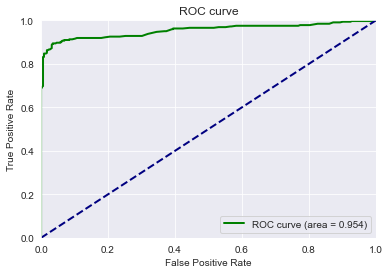

combined: 0.954


In [35]:
evaluate_seperate_chains(clf_alpha, clf_beta, x_mean_imputed, y, x_test_mean_imputed, y_test)

## HistGradientBoosting - HistGradientBoosting

In [36]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_alpha = HistGradientBoostingClassifier(random_state=0)
clf_beta = HistGradientBoostingClassifier(random_state=0)

alpha: 0.9223712131473205
beta: 0.9170346291028941


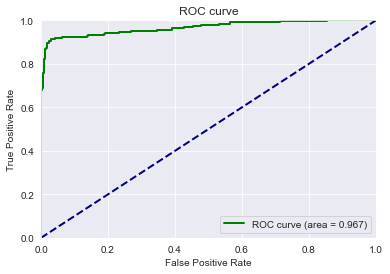

combined: 0.967


In [37]:
evaluate_seperate_chains(clf_alpha, clf_beta, x, y, x_test, y_test)

## XGBoost - XGBoost

In [38]:
from xgboost import XGBClassifier
clf_alpha = XGBClassifier(random_state=0)
clf_beta = XGBClassifier(random_state=0)

alpha: 0.9166373199692988
beta: 0.9285475642241185


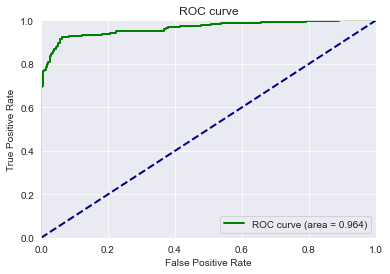

combined: 0.964


In [39]:
evaluate_seperate_chains(clf_alpha, clf_beta, x, y, x_test, y_test)

## HistGradientBoosting - XGBoost

In [43]:
clf_alpha = HistGradientBoostingClassifier(random_state=0)
clf_beta = XGBClassifier(random_state=0)

alpha: 0.922
beta: 0.929


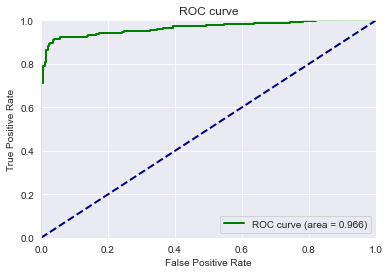

combined: 0.966


In [44]:
evaluate_seperate_chains(clf_alpha, clf_beta, x, y, x_test, y_test)